In [25]:
import sys; sys.path.append('../../')
from DataPreparation.DataPreparation import read_data, convey_insights
from ModelPipelines.ModelAnalysis import recursive_feature_elimination, test_log_linearity,log_weights_analysis, show_hyperparams, vc_dimension_check,validation_curves,learning_curves, BiasVariance
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from HandleClassImbalance.HandleClassImbalance import *
from ModelPipelines.ModelVisualization import VisualizeModel
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import clear_output, HTML
from scipy.stats import loguniform
from utils import nice_table, save_hyperparameters, load_hyperparameters, get_metrics
import numpy as np
model_name = 'Perceptron'

# <font color="LemonChiffon">Perceptron</font> Analysis

### Initialization

In [26]:
x_data_d, y_data_d = read_data(kind='Numerical')
opt_params = load_hyperparameters(model_name)
clf = Perceptron(**opt_params)
clf.fit(x_data_d, y_data_d)

show_hyperparams(clf)
convey_insights([
    "Interesting hyperparameter is eta0 (Learning Rate)."
])

alpha,class_weight,early_stopping,eta0,fit_intercept,l1_ratio,max_iter,n_iter_no_change,n_jobs,penalty,random_state,shuffle,tol,validation_fraction,verbose,warm_start
0.5354,None,False,0.90909,True,0.15,1000,5,None,None,0,True,0.001,0.1,0,False


<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> Interesting hyperparameter is eta0 (Learning Rate).<br><br></font>

<h2><font color="LemonChiffon"> Model Analysis </font></h2>

### Test Model Assumptions

### VC Dimension

In [27]:
vc_dimension_check(clf, x_data_d)

<font size=4>By estimating the VC dimension of the model, 
                    we have $d_{vc}=37$. 
                    Since, $N=1180$, it holds that 
                    $$N \geq 10d_{vc}$$
                    Hence, model is expected to have no issues with generalization.
                    </font>
                    

### Bias-Variance

In [28]:
BiasVariance(clf, x_data_d, y_data_d)
convey_insights([
    "Accuracy and WF1 don't differ much.",
    "Variance is too low, seems to be no overfitting.",
    "Bias is slightly high."
])

Train WF1,Val WF1,Aviodable Bias,Variance
0.764,0.799,0.236,-0.035


<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> Accuracy and WF1 don't differ much.<br><br><font color="pink">✦</font> Variance is too low, seems to be no overfitting.<br><br><font color="pink">✦</font> Bias is slightly high.<br><br></font>

### Learning Curve

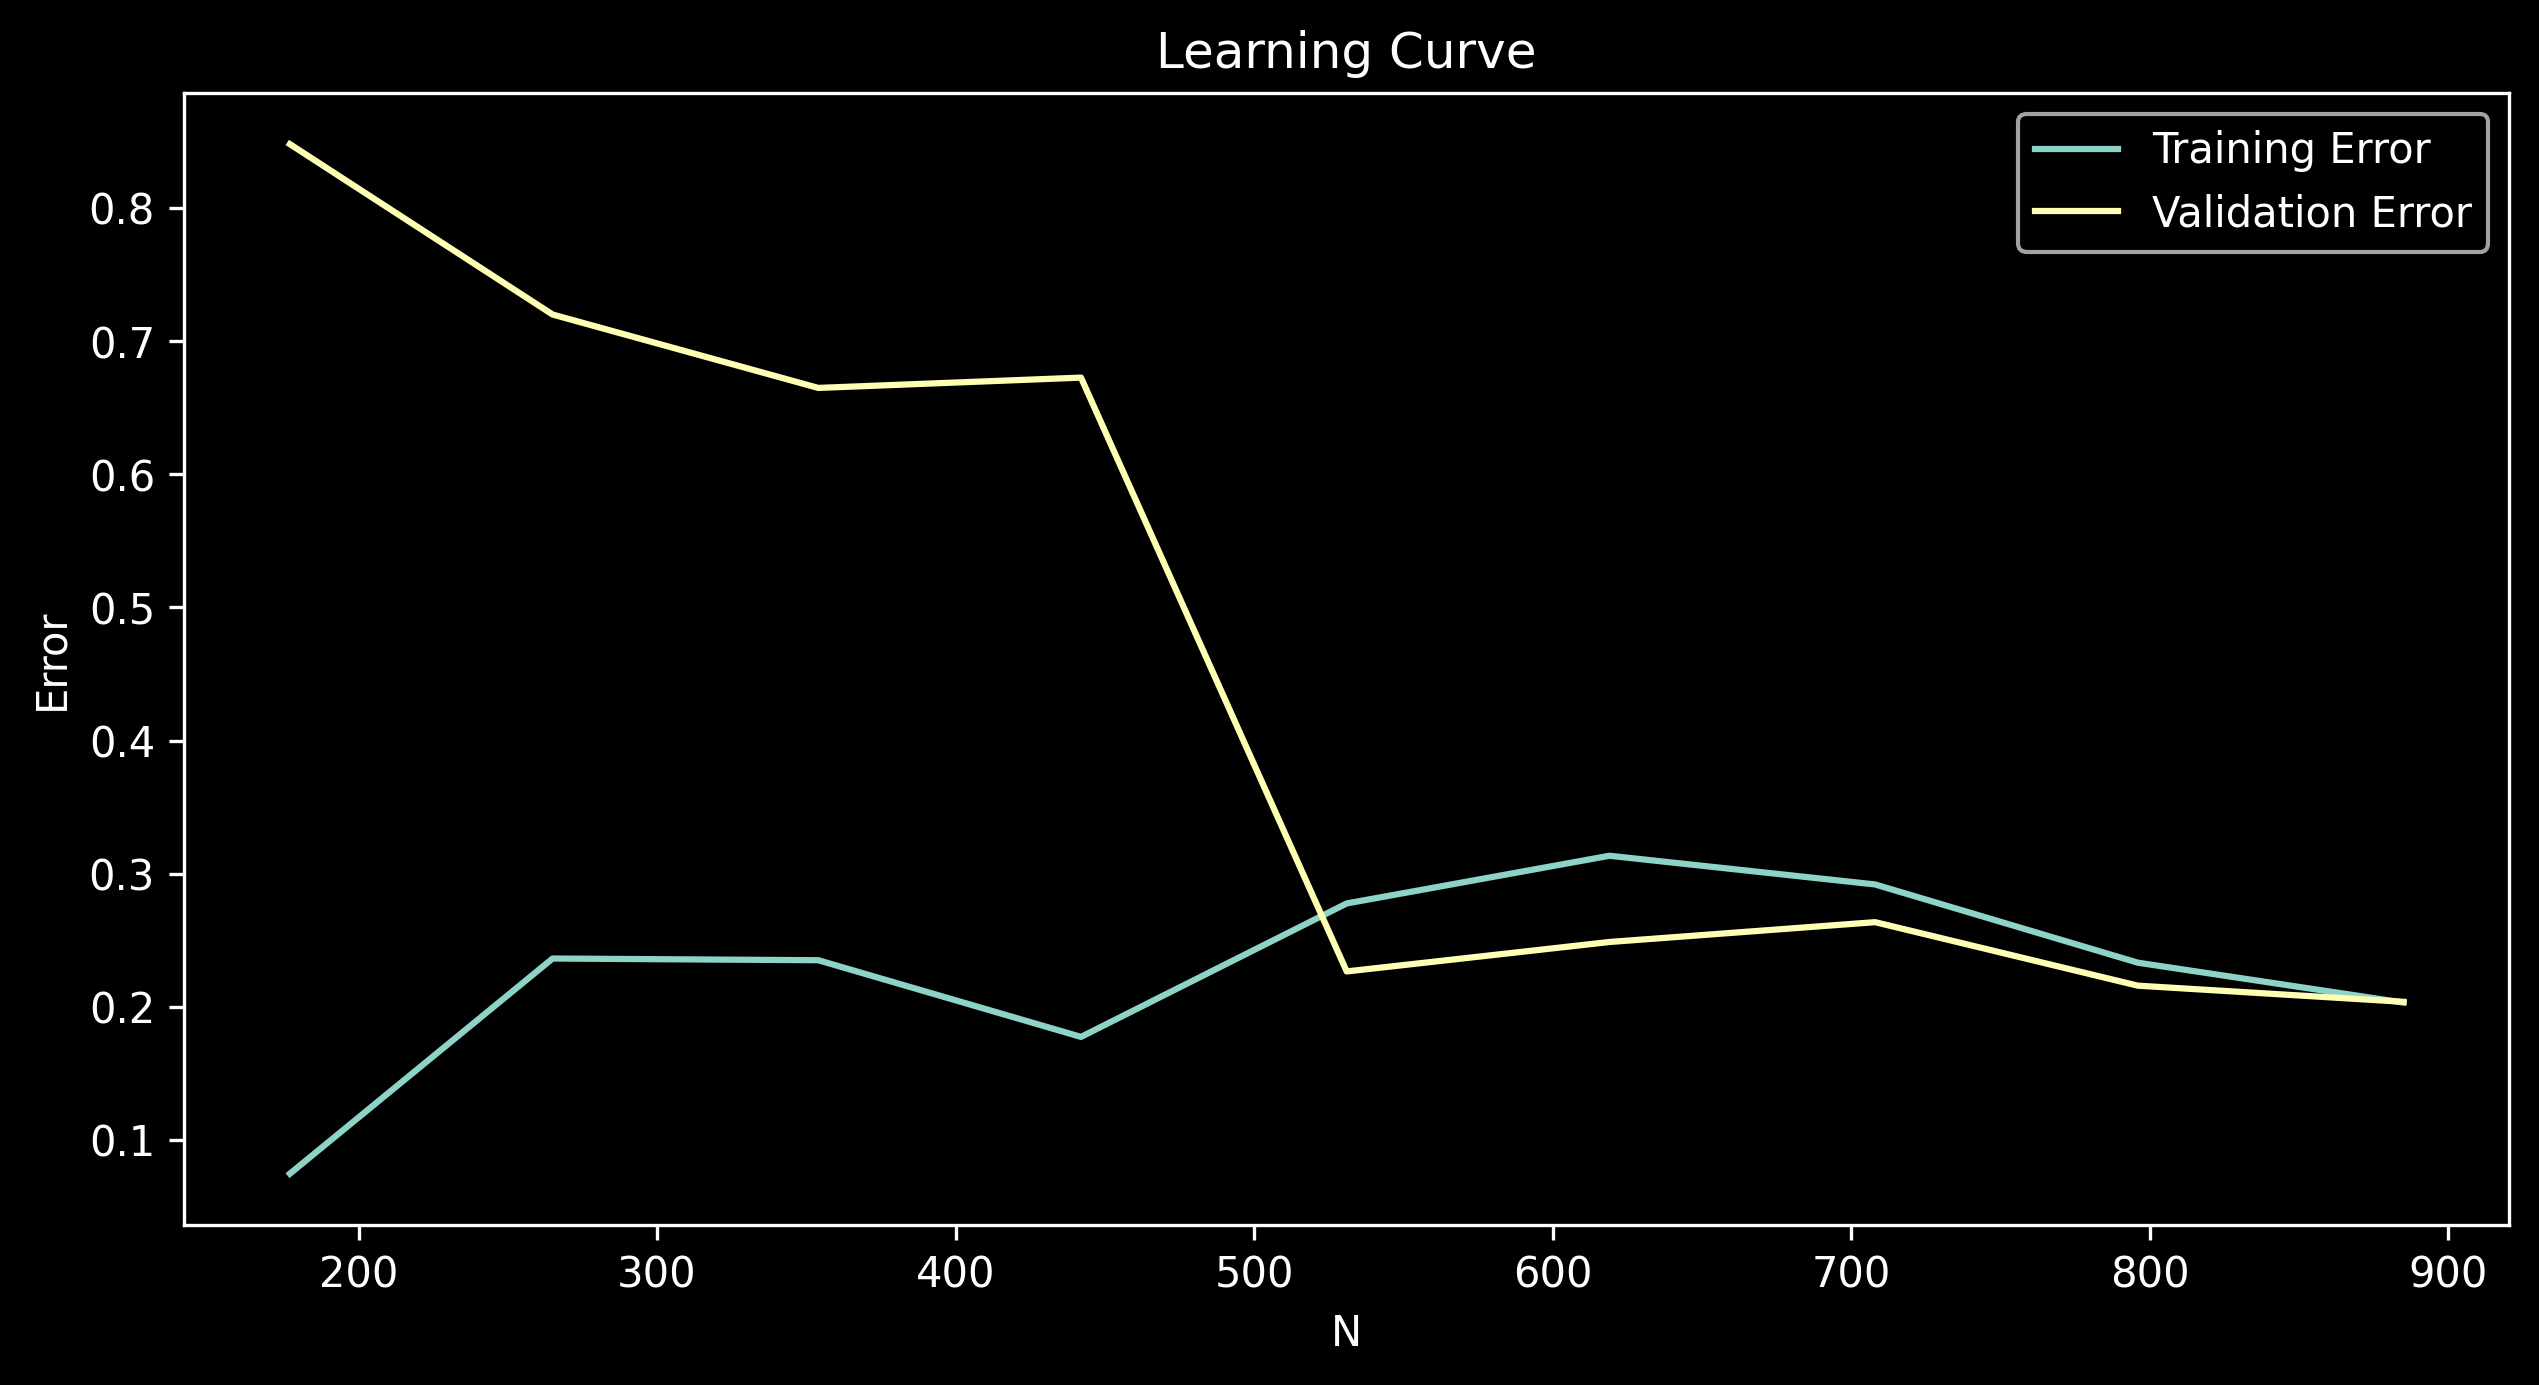

In [29]:
train_sizes=np.linspace(0.1, 1.0, 10)
learning_curves(clf, x_data_d, y_data_d, cv=4,N=train_sizes)


<h2><font color="LemonChiffon"> Hyperparameter Analysis </font></h2>

### Regularization & Overfitting

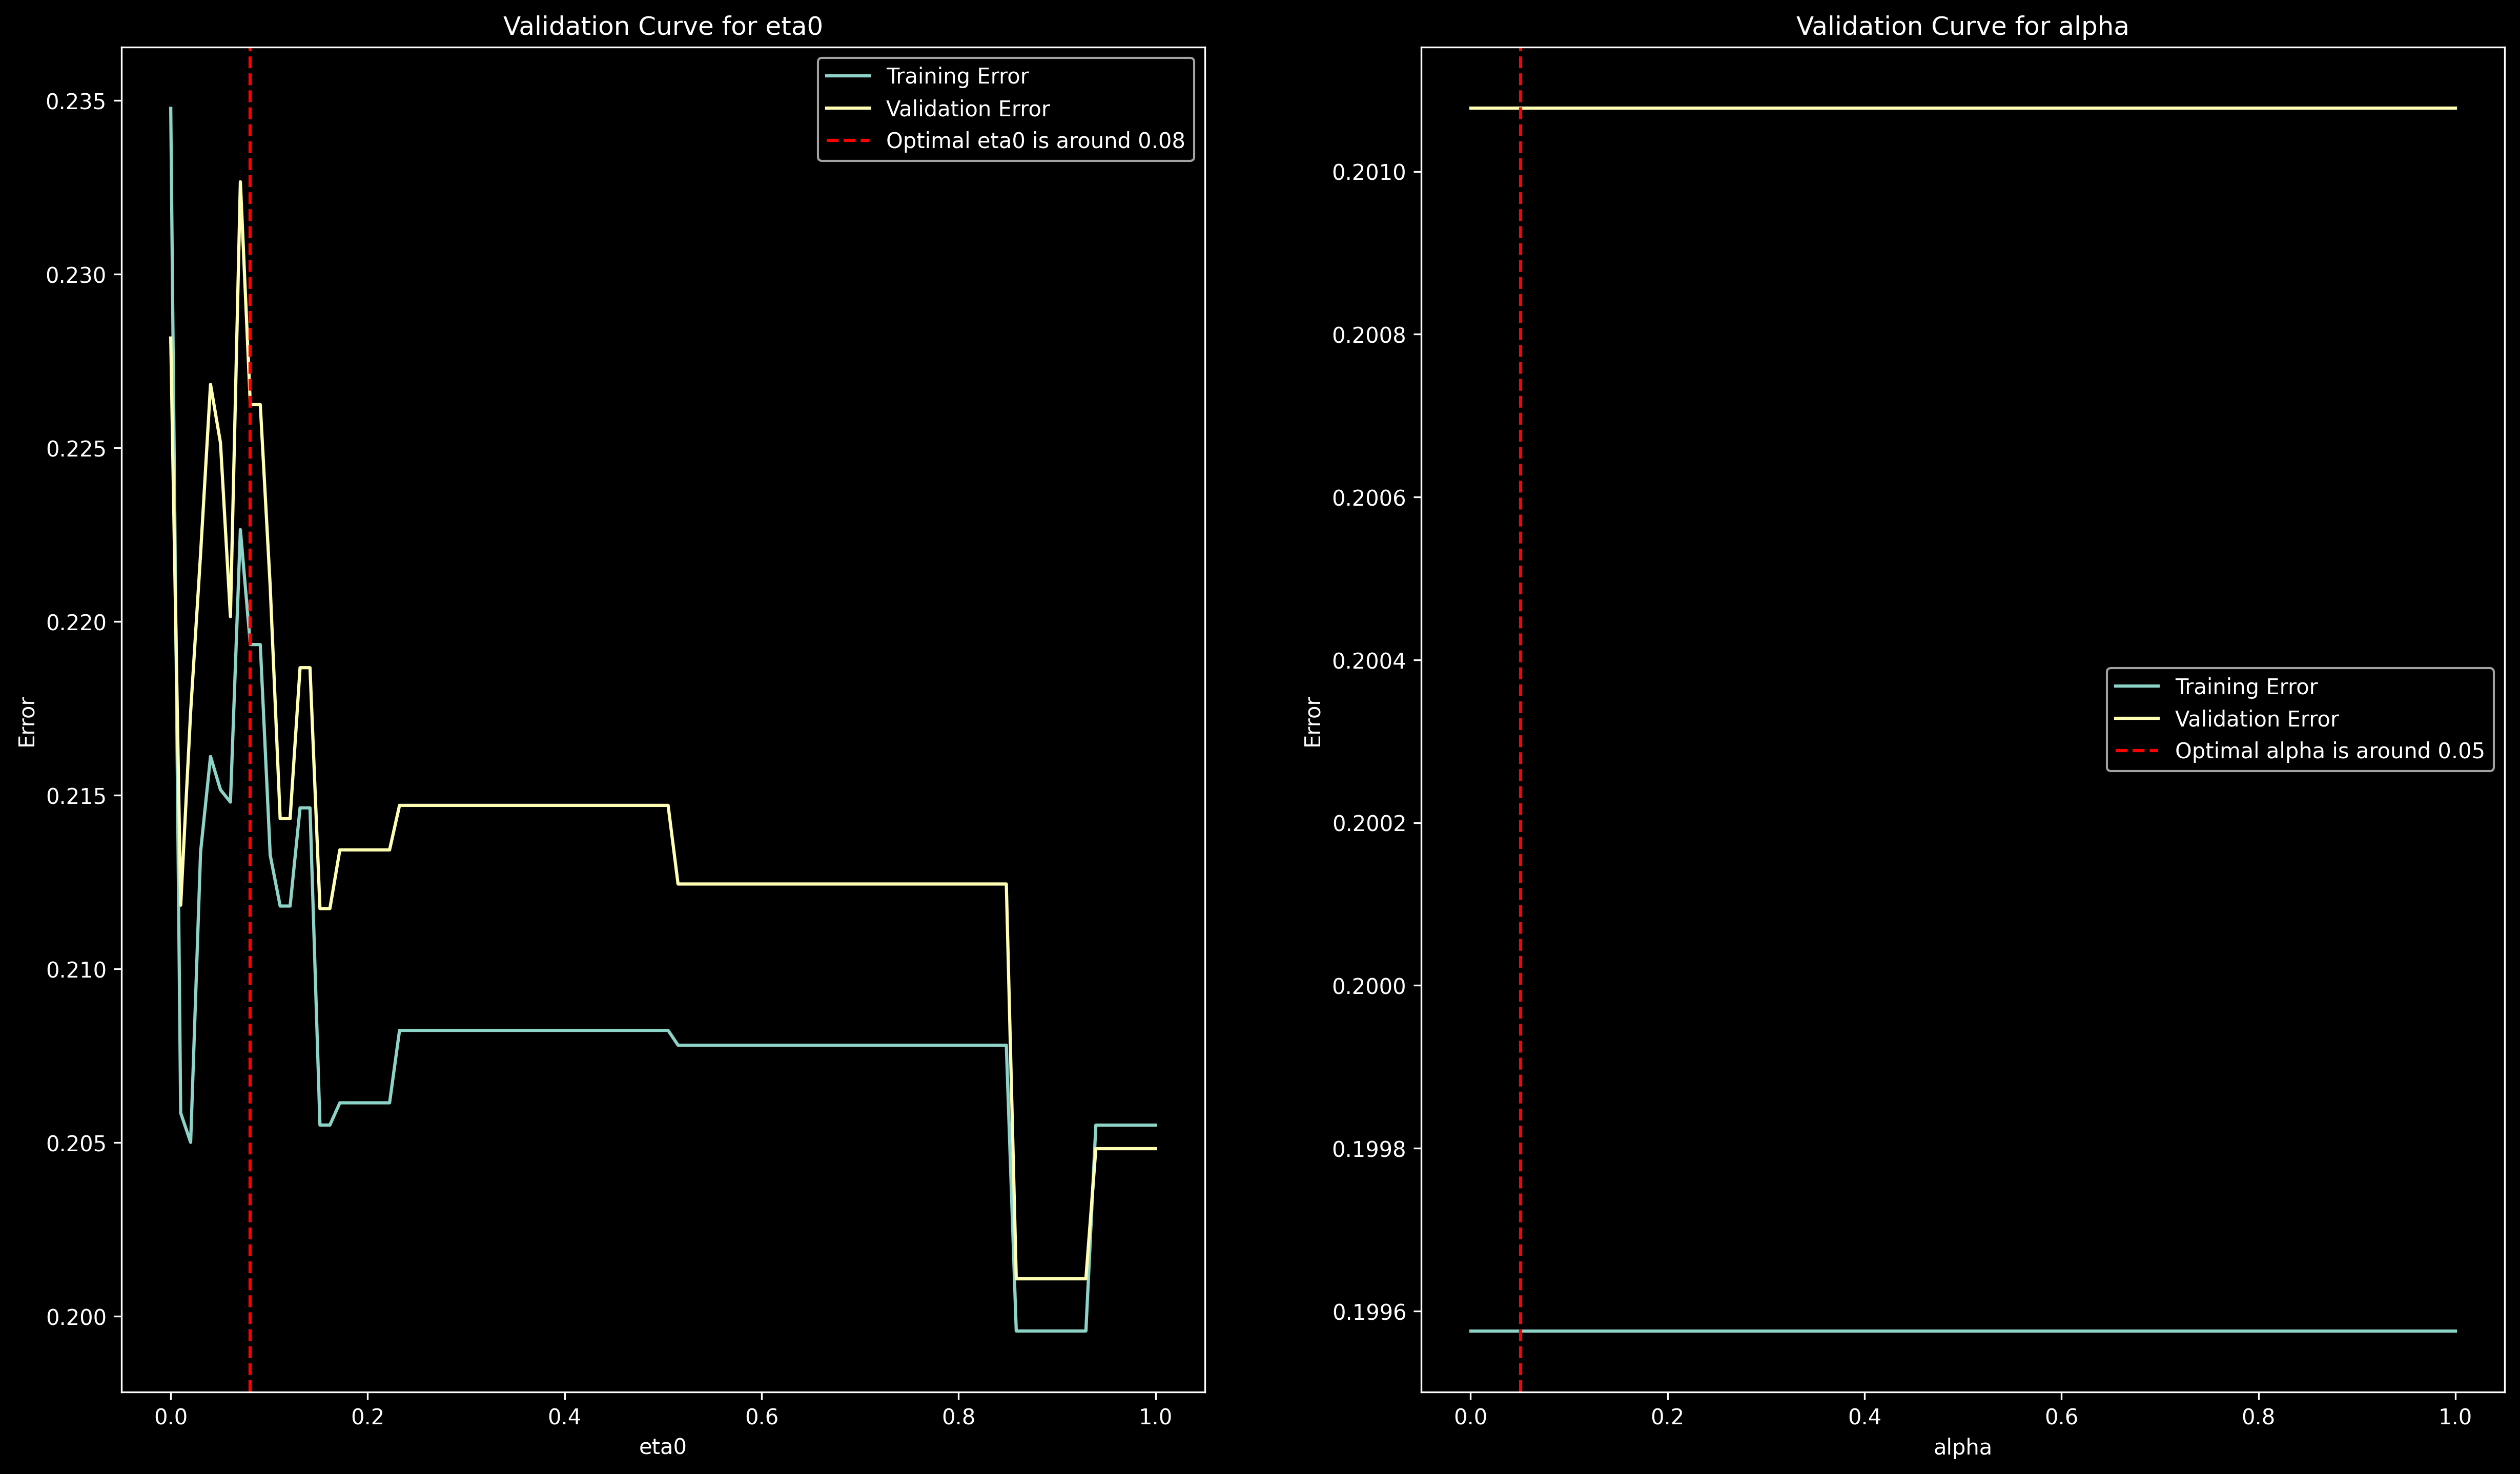

<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> Since we have slightly high bias, there's lots of regions (in learning rate curve) that suffer from underfitting.<br><br><font color="pink">✦</font> Alpha seems to have no effect here.<br><br></font>

In [30]:
x_data_d, y_data_d = read_data(kind='Numerical')
clf = Perceptron(**opt_params)
clf.fit(x_data_d, y_data_d)

# Reasonable values for eta0 are larger than zero(larger than 1e-8 or 1e-10) and probably less than 1.0

hyperparameters= {'eta0': np.linspace(1e-10, 1.0, 100), 'alpha': np.linspace(0.0001, 1.0, 100)}

validation_curves(clf,x_data_d,y_data_d,5,hyperparameters)

convey_insights([
    "Since we have slightly high bias, there's lots of regions (in learning rate curve) that suffer from underfitting.",
    "Alpha seems to have no effect here.",
])

### Hyperparameter Search

In [31]:
opt_params = {}
param_dist = {
    'eta0': np.linspace(0, 1.0, 100),
    'alpha': np.linspace(0.0001, 1.0, 100),
}

h_clf = Perceptron()
random_search = RandomizedSearchCV(estimator=h_clf, param_distributions=param_dist, n_iter=100,
                                scoring='accuracy', n_jobs=4, cv=5, random_state=42)
random_search.fit(x_data_d, y_data_d)

opt_params = random_search.best_params_
clear_output(wait=False)

opt_params['accuracy'] = random_search.best_score_
display(HTML(nice_table(opt_params, 'Optimal Configuration')))
opt_params.pop('accuracy', None)

# save hyperparameters
save_hyperparameters(model_name, opt_params)

convey_insights([
    "May not strongly rely on this due validation set contamination.",
    "If we do, we have held out another validation set to compare models."
])

eta0,alpha,accuracy
0.90909,0.5354,0.80085


<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> May not strongly rely on this due validation set contamination.<br><br><font color="pink">✦</font> If we do, we have held out another validation set to compare models.<br><br></font>

<h2><font color="LemonChiffon"> Features Analysis </font></h2>

### Feature Importance Analysis

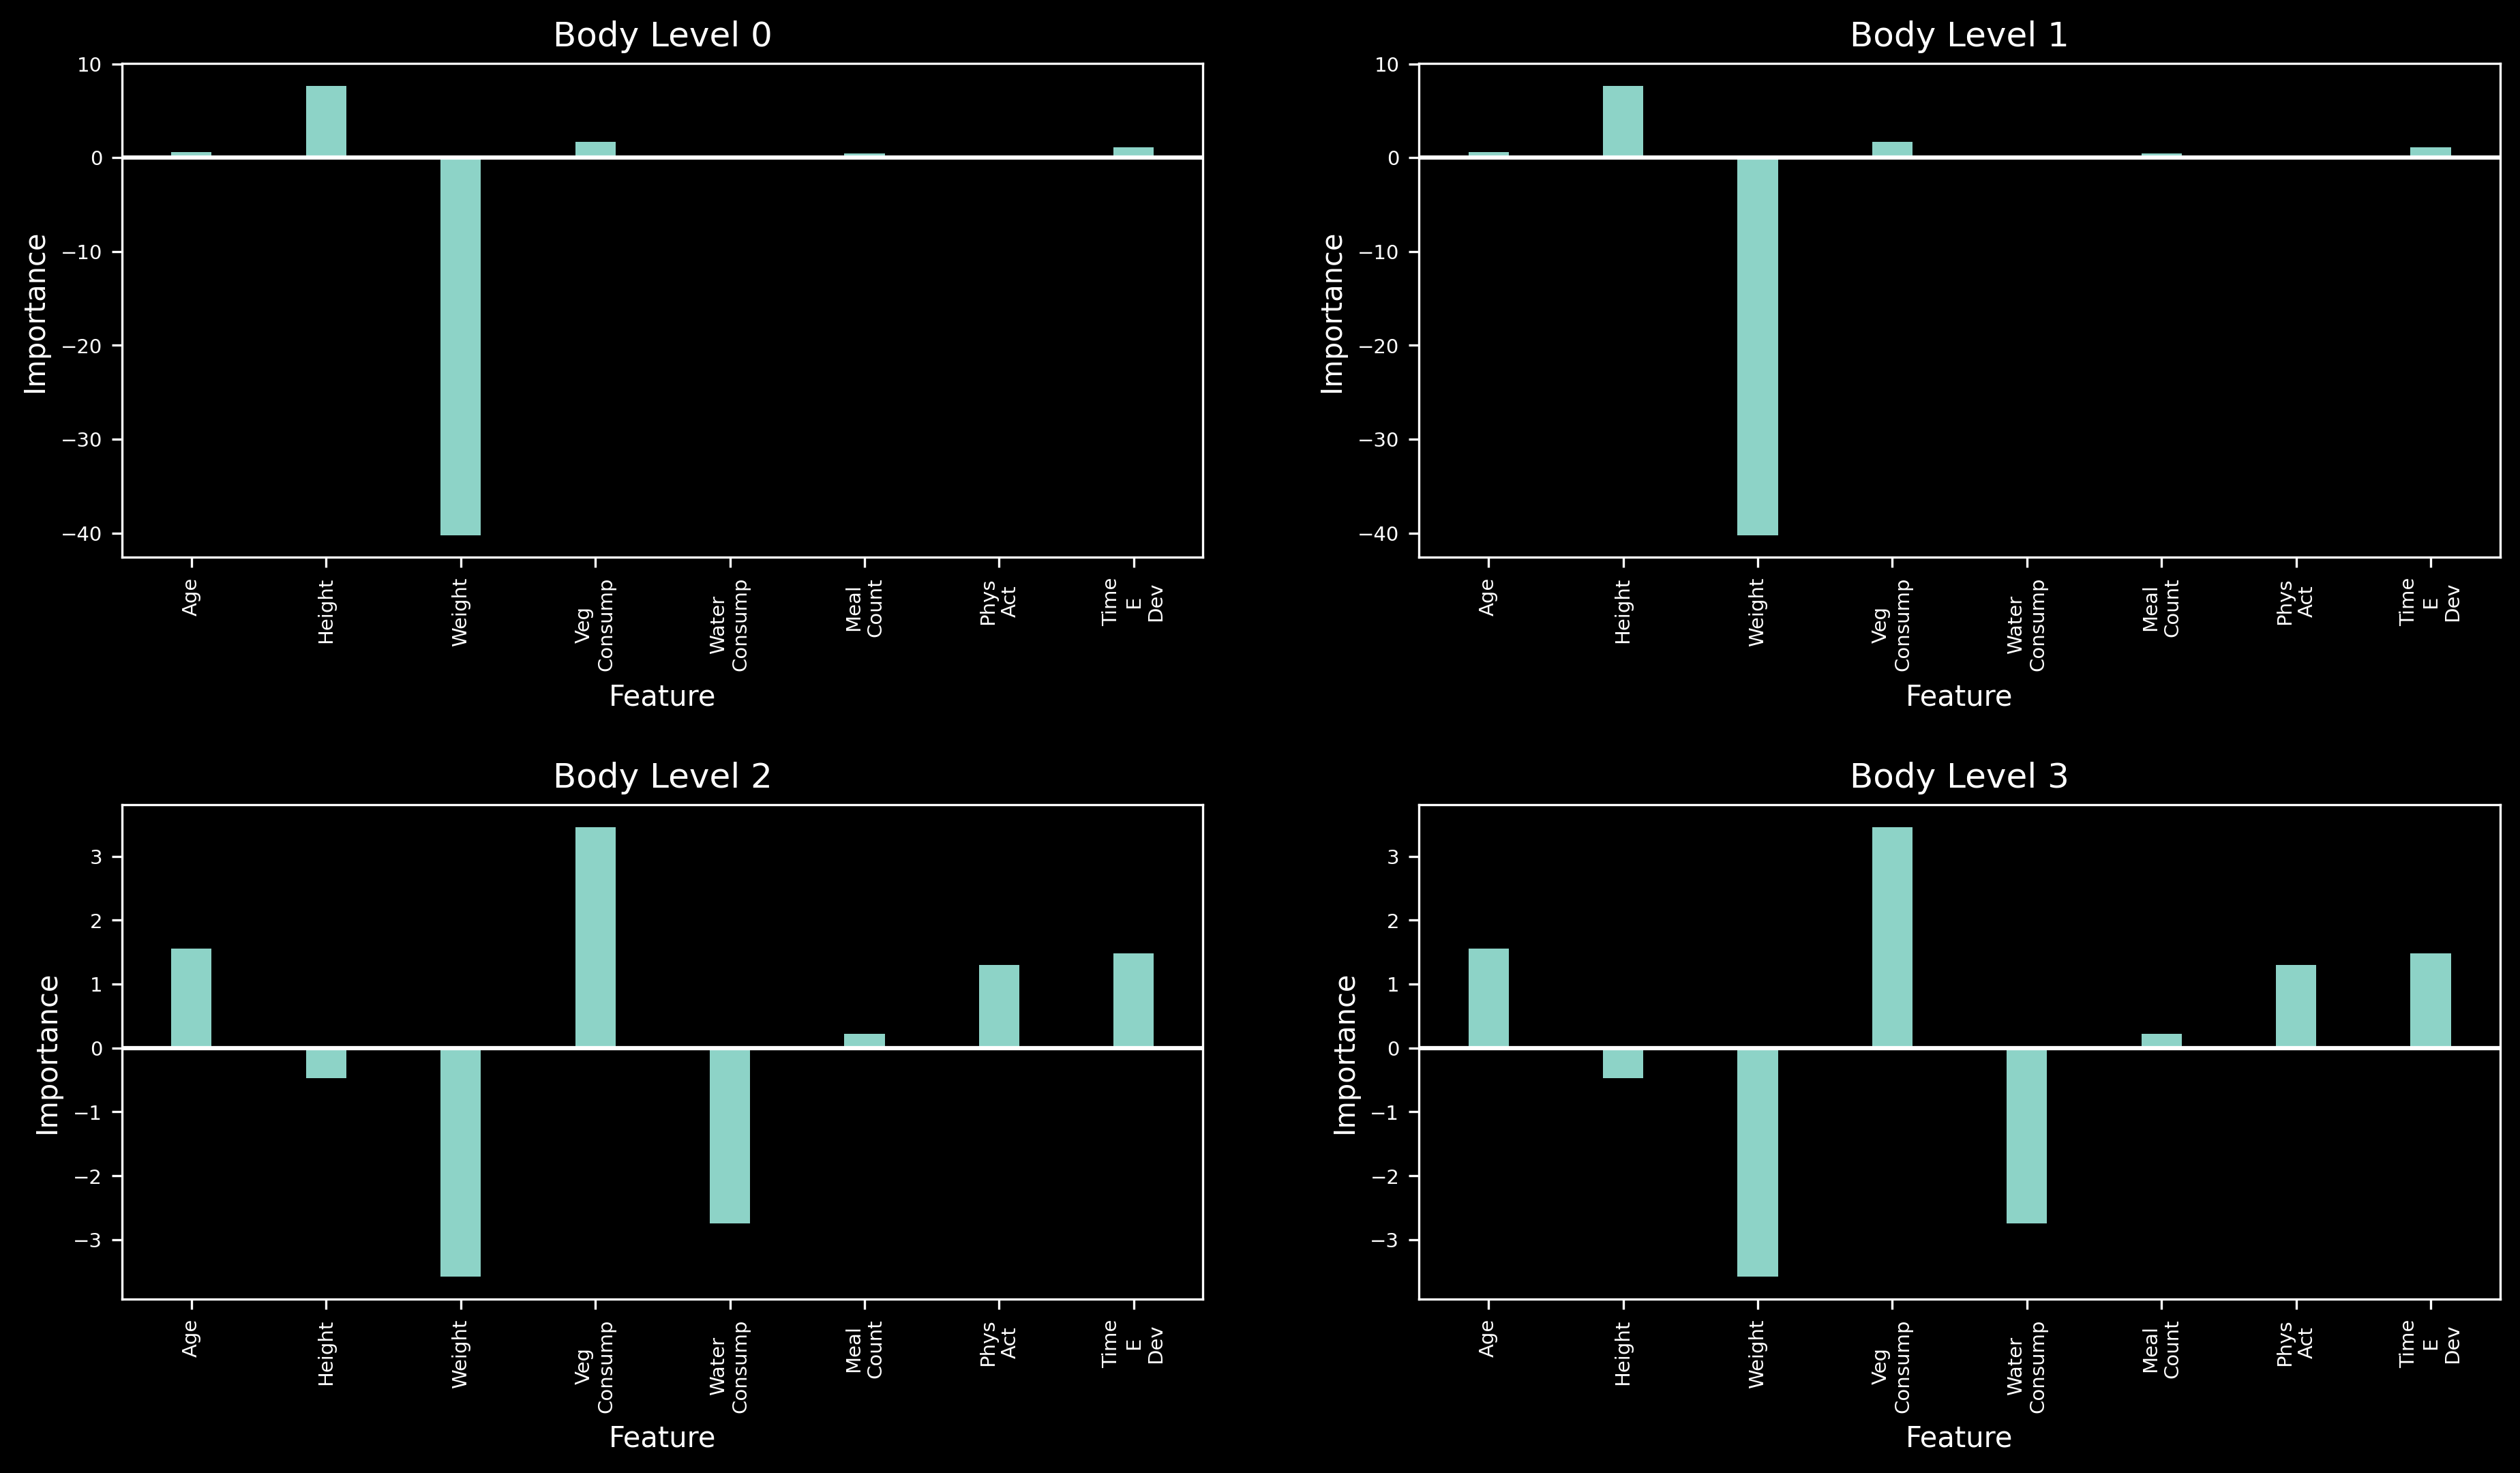

<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> Weight, height and Veg_Consump seem to be most relevant to descriminate the classes<br><br><font color="pink">✦</font> Phys_Act, Time_E_Dev and Water_Consump are of less importance but can still be effective in descrimating the classes.<br><br><font color="pink">✦</font> The rest of the features are not very useful in descriminating the classes.<br><br></font>

In [32]:
log_weights_analysis(clf, x_data_d)

convey_insights([
    "Weight, height and Veg_Consump seem to be most relevant to descriminate the classes",
    "Phys_Act, Time_E_Dev and Water_Consump are of less importance but can still be effective in descrimating the classes.",
    "The rest of the features are not very useful in descriminating the classes."
      
])

### Recursive Feature Elimination

Phys_Act,Water_Consump,Time_E_Dev,Veg_Consump,Height,Weight
0.51903,1.065,1.096,1.88,5.941,16.494


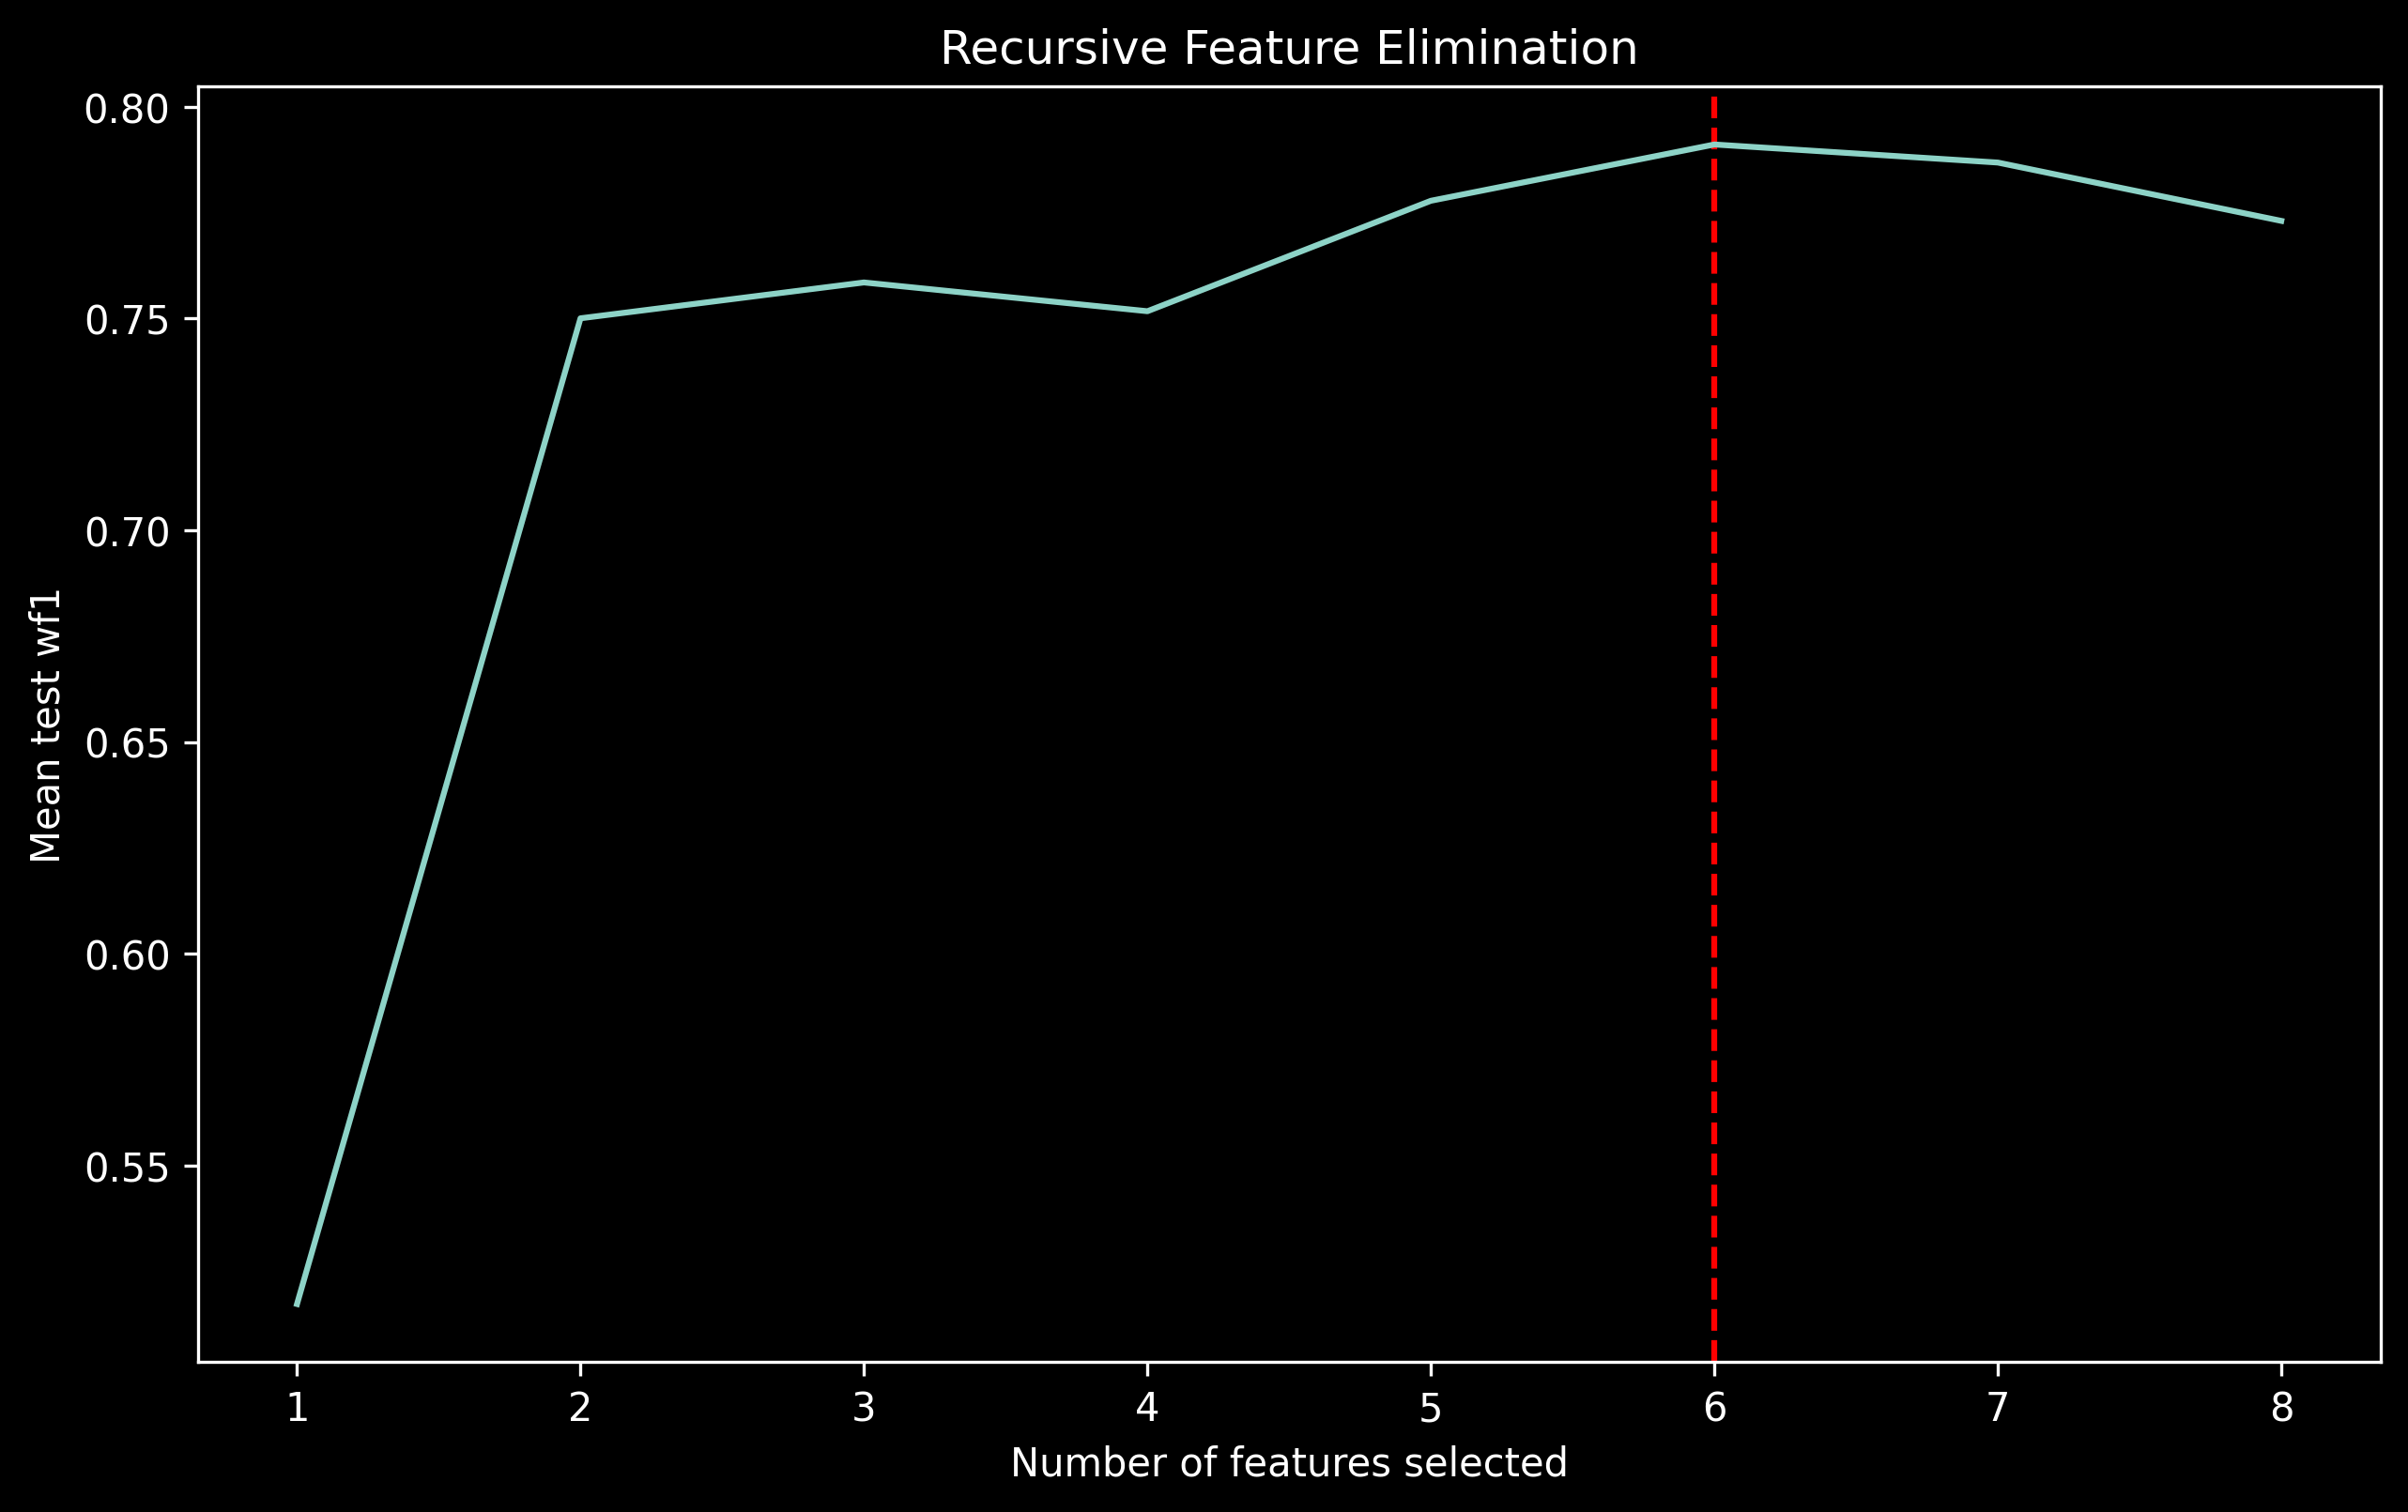

<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> Results do match expectations<br><br></font>

In [33]:
x_data_r = recursive_feature_elimination(clf, min_feats=1, cv=10, x_data_d=x_data_d, y_data_d=y_data_d)
convey_insights([
    "Results do match expectations",
])

<h2><font color="LemonChiffon"> Class Imbalance Analysis </font></h2>

### Testing Cost Sensitive & Sampling Methods

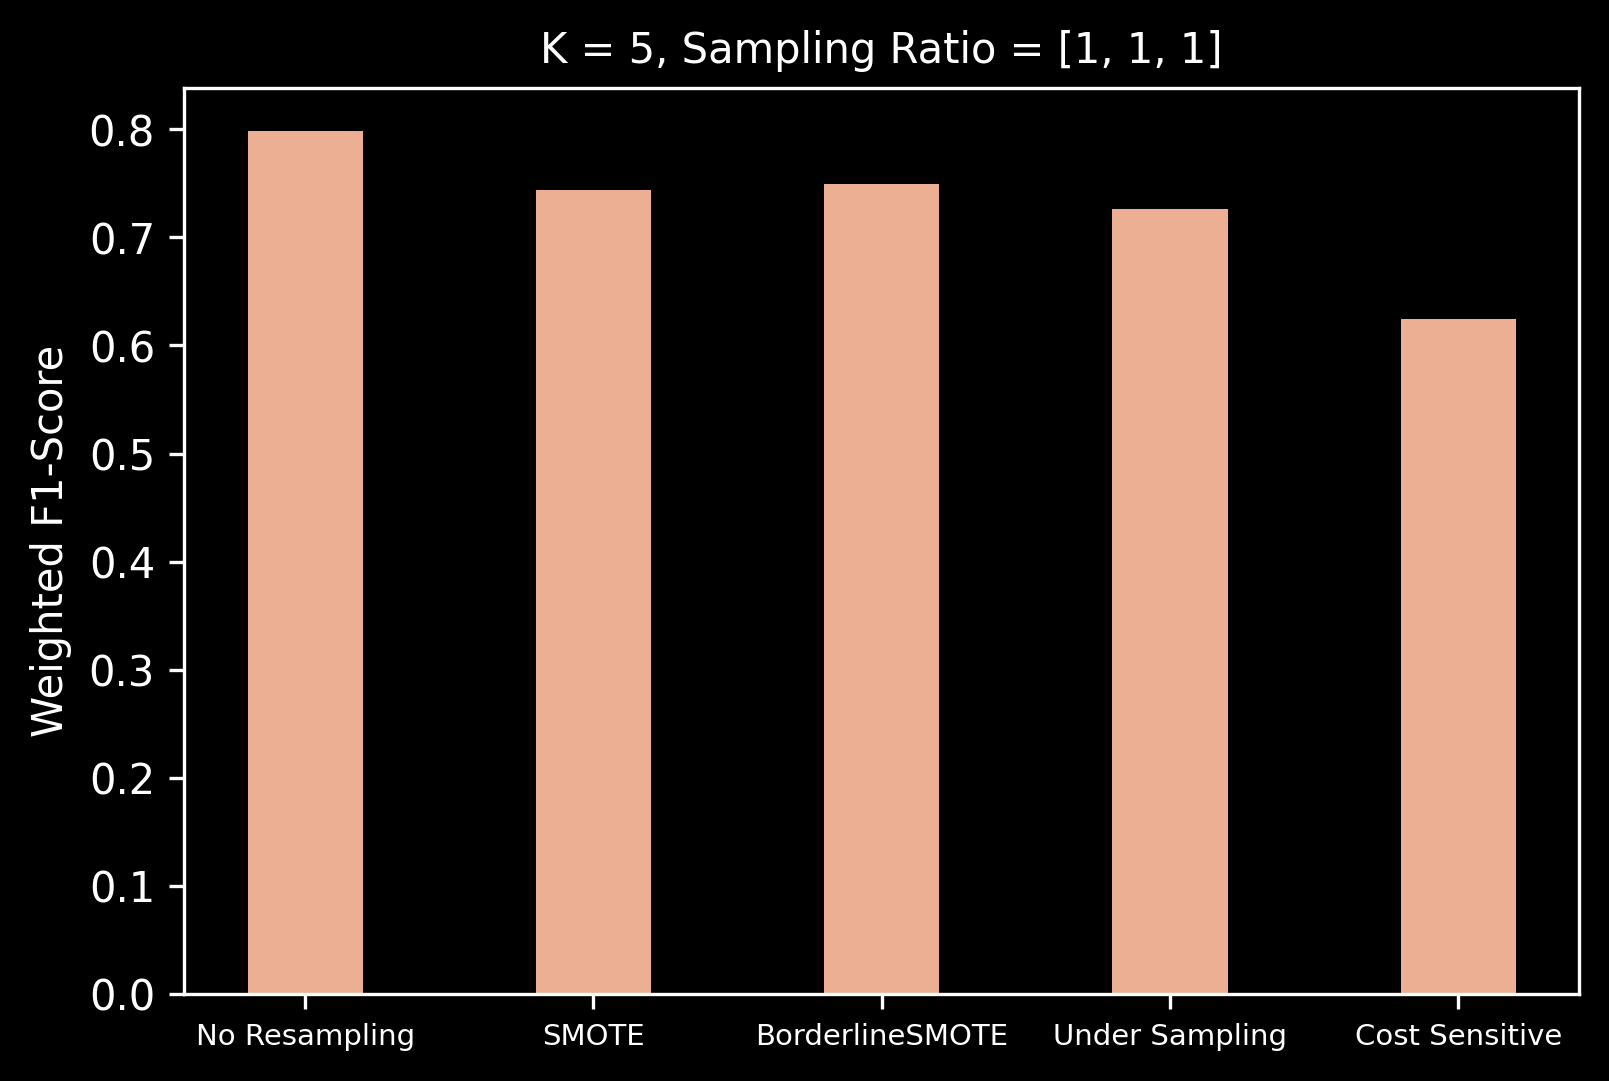

<Figure size 1800x1500 with 0 Axes>

In [34]:
### 1- evaluate All resampling methods and cost sensitive
methods=['No Resampling', 'SMOTE','BorderlineSMOTE','Under Sampling','Cost Sensitive']
sample_ratio=[1,1,1]
k=5
evaluate_class_imbalance_handler_over_methods(x_data_d,y_data_d ,clf , methods=methods , sample_ratio=[1,1,1], k=k)

### Evaluate Oversampling Methods for different K values and sampling ratios

<Figure size 1800x1200 with 0 Axes>

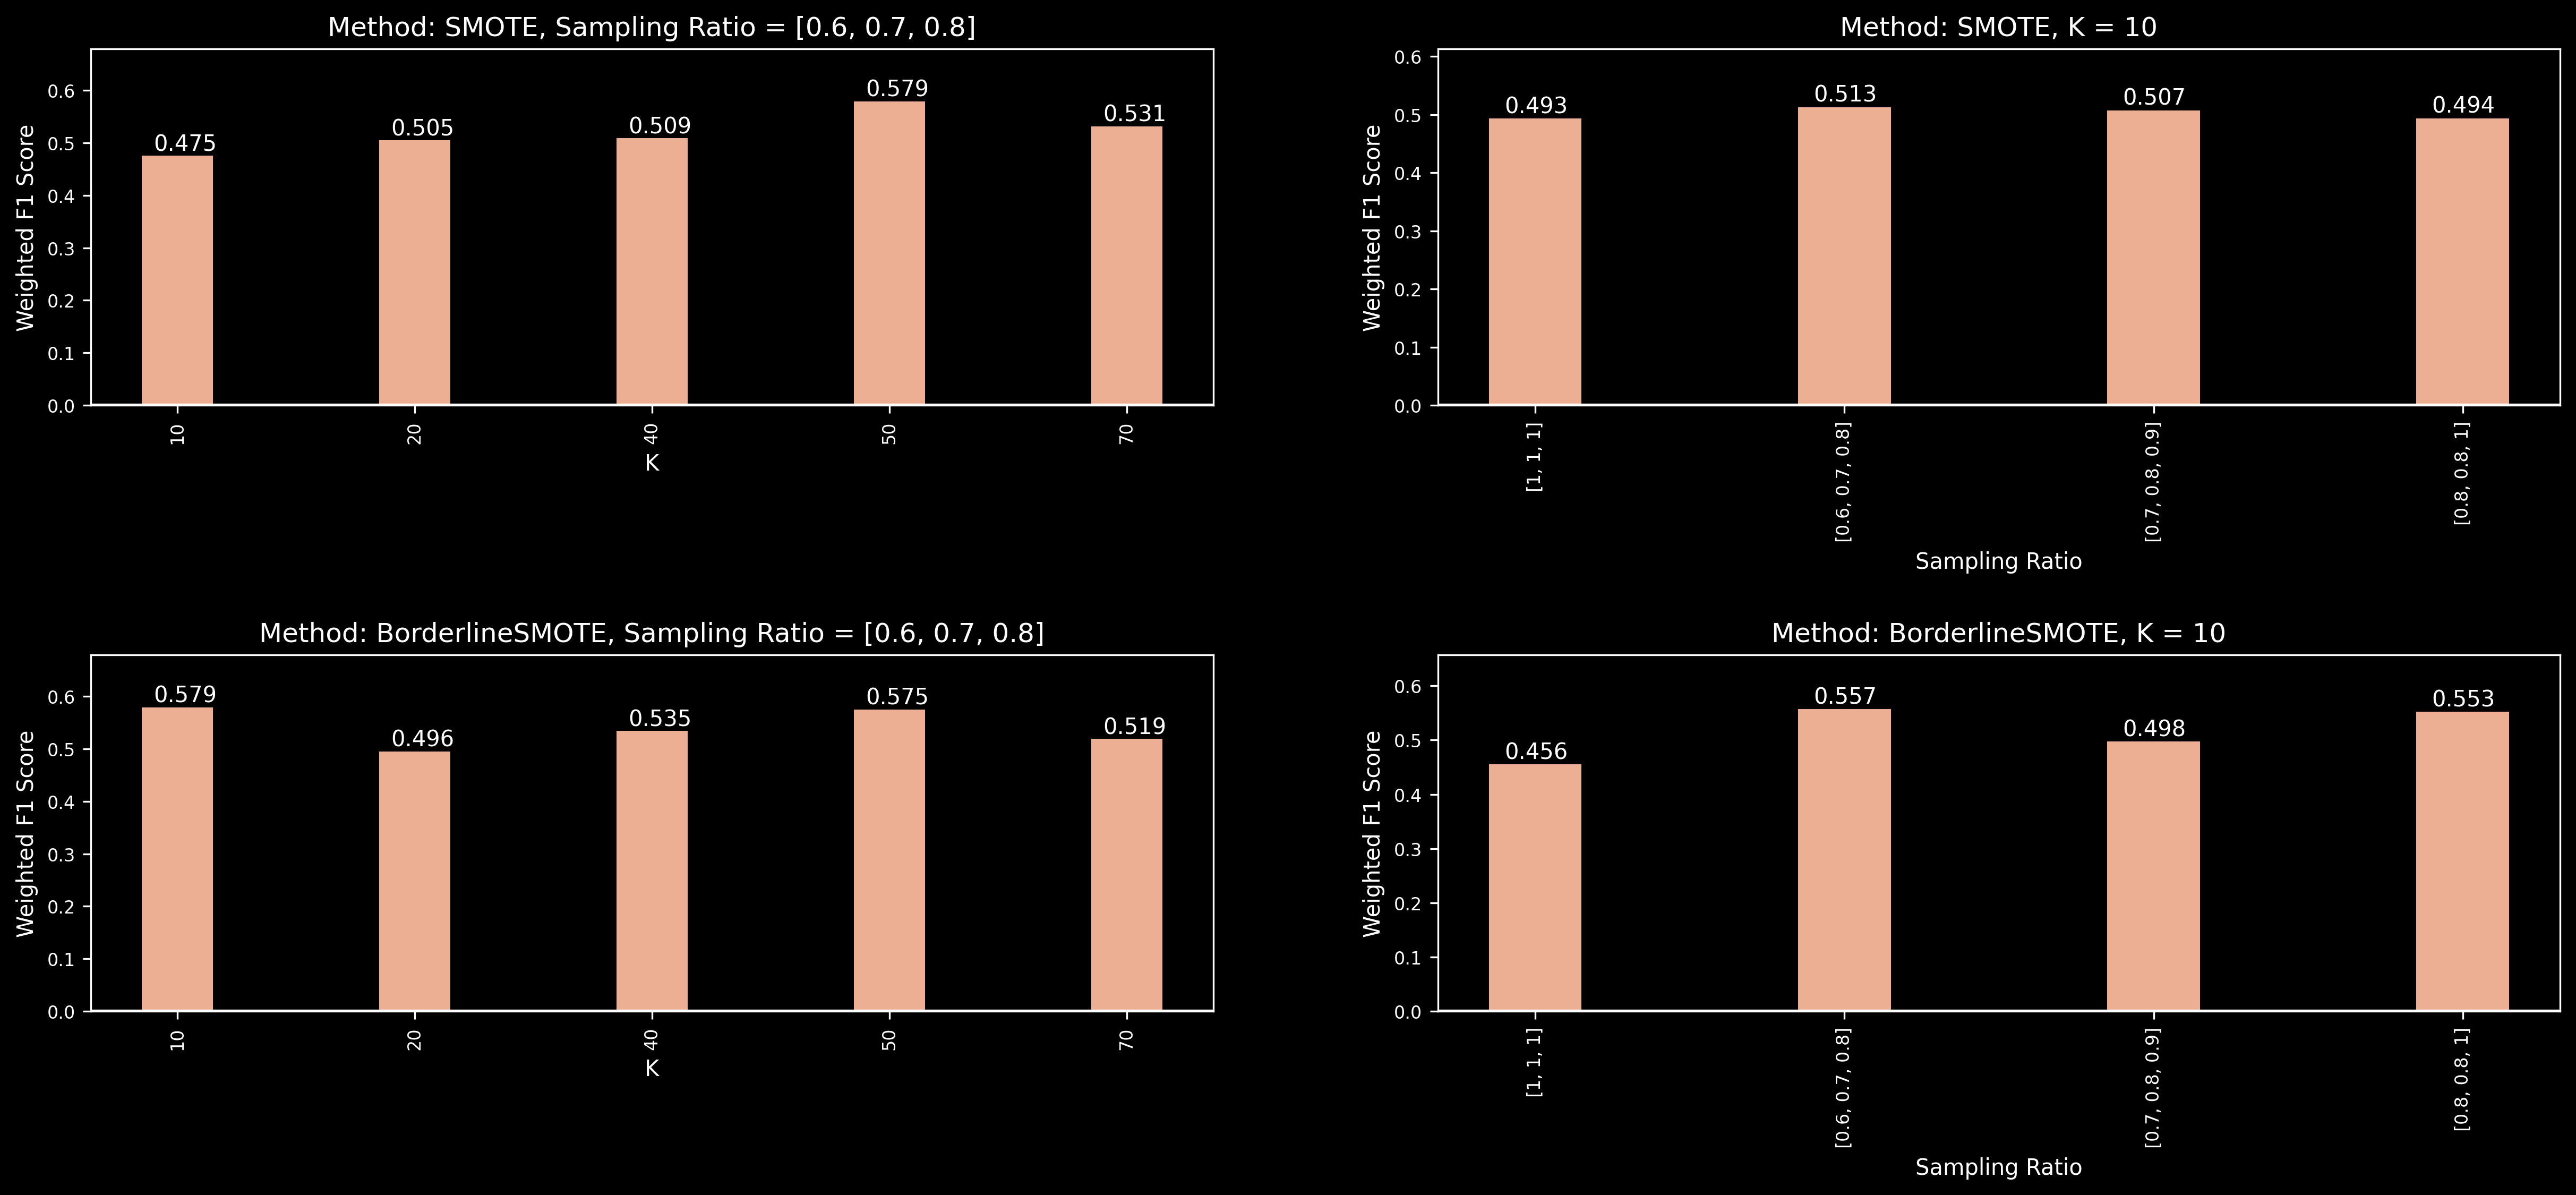

<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> Class imbalance seems to decrease the weighted F1 score of the model<br><br></font>

In [35]:
methods = ['SMOTE', 'BorderlineSMOTE']
sample_ratios=[[1,1,1],[0.6,0.7,0.8],[0.7,0.8,0.9], [0.8,0.8,1] ]
const_k=10
const_sample_ratio=[0.6,0.7,0.8] 
Ks=[10,20,40,50,70]

plot_different_evaluations(x_data_d,y_data_d ,clf , methods=methods , sample_ratios=sample_ratios, Ks=Ks, const_k=const_k, const_sample_ratio=const_sample_ratio)


convey_insights([
    "Class imbalance seems to decrease the weighted F1 score of the model",
])

<h2><font color="LemonChiffon"> Model Visualization </font></h2>

#### Final Model

In [36]:
VisualizeModel(model_name, x_data_r, y_data_d, clf).double_whammy(animated=True)
convey_insights([
    "Isn't it beautiful?",
])

f:\Fourth Year 2nd term\Machine Learning\ML_Project\ModelPipelines\Perceptron\../..\ModelPipelines\ModelVisualization.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gif1 = np.array(gif1)


ValueError: could not broadcast input array from shape (800,1200,4) into shape (800,1200)